In [3]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
client = Client(n_workers=4)
print(dgpd.__version__)
client


C:\Users\20191\AppData\Local\Temp\ipykernel_17924\439571931.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


v0.3.1


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53920,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:53950,Total threads: 4
Dashboard: http://127.0.0.1:53951/status,Memory: 3.92 GiB
Nanny: tcp://127.0.0.1:53923,


### Load and preprocess dataset

In [6]:
def convert_timezone(utc_df: pd.DataFrame,
                     target_tz: str = "America/New_York",
                     columns: list = ["pick_up_time", "drop_off_time"]):
    new_timezone_df = utc_df.copy()
    start_col, end_col = columns[0], columns[1]
    new_timezone_df[start_col] = new_timezone_df[start_col].dt.tz_convert(
        target_tz)
    new_timezone_df[end_col] = new_timezone_df[end_col].dt.tz_convert(
        target_tz)
    return new_timezone_df

def intersection_to_road(roads,intersections_raw):
    from shapely.geometry import LineString
    merge_start = roads.merge(intersections_raw, left_on="node1", right_on="id")
    merge_start['geom_node1'] = gpd.points_from_xy(merge_start['longitude'],
                                                merge_start['latitude'])
    merge_start = merge_start[['node1', 'node2', 'geom_node1']]
    merge_start = merge_start.merge(intersections_raw,
                                    left_on="node2",
                                    right_on="id")
    merge_start['geom_node2'] = gpd.points_from_xy(merge_start['longitude'],
                                                merge_start['latitude'])
    merge_start = merge_start[['node1', 'node2', 'geom_node1', 'geom_node2']]
    merge_start['geometry'] = merge_start.apply(
        lambda x: LineString([x['geom_node1'], x['geom_node2']]), axis=1)
    merge_start = merge_start[['node1', 'node2', 'geometry']]
    road_gdf = gpd.GeoDataFrame(merge_start,
                                        geometry="geometry",
                                        crs="epsg:4326")
    return road_gdf


In [5]:
# raw data
raw_taxi_df = dd.read_csv(r'./raw_data/taxi_id.csv',
                 blocksize=64e6,
                 names=[
                     'taxi_id', 'pick_up_time', 'drop_off_time',
                     'pick_up_intersection', 'drop_of_intersection'
                 ])
roads = pd.read_csv(r'./raw_data/roads.csv',index_col=None,names=['node1',"node2","geom"])
intersections_raw = pd.read_csv(r'./raw_data/intersections.csv',
                                names=['id', 'latitude', 'longitude'])
boundary = gpd.read_file(r"./raw_data/taxi_zones.shp")

# Unix epoch timestamp correspond to UTC
raw_taxi_df['pick_up_time'] = dd.to_datetime(raw_taxi_df['pick_up_time'],
                                             unit='s',
                                             utc=True)
raw_taxi_df['drop_off_time'] = dd.to_datetime(raw_taxi_df['drop_off_time'],
                                              unit="s",
                                              utc=True)
raw_taxi_df['trip_date'] = raw_taxi_df['pick_up_time'].dt.date

# a copy of raw_df with timezone transforming in datetime field
nytz_df = convert_timezone(raw_taxi_df).drop(
    ['drop_off_time', 'pick_up_intersection', "drop_of_intersection"], axis=1)

# extract trip_date and trip_hour in local time
nytz_df['trip_date'] = nytz_df['pick_up_time'].dt.strftime('%Y-%m-%d')
nytz_df['trip_hour'] = nytz_df['pick_up_time'].dt.strftime('%H')
nytz_df.head()


,taxi_id,pick_up_time,trip_date,trip_hour
0,1,2010-12-31 19:00:00-05:00,2010-12-31,19
1,2,2010-12-31 19:00:01-05:00,2010-12-31,19
2,3,2010-12-31 19:00:03-05:00,2010-12-31,19
3,4,2010-12-31 19:00:04-05:00,2010-12-31,19
4,5,2010-12-31 19:00:07-05:00,2010-12-31,19


### Task 1.1 How many unique taxis?

In [7]:
print(f"Number of unique taxi: {raw_taxi_df['taxi_id'].nunique().compute()}")
# The answer is 13385


Number of unique taxi: 13385


### Task 1.2 How many trips are recorded?

In [8]:
print(f"Trips before dropping NA: {len(raw_taxi_df.index.compute())}")
print(f"Trips after dropping NA: {len(raw_taxi_df.dropna().index.compute())}")
# Number of trips: 147800095

Trips before dropping NA: 147800095
Trips after dropping NA: 147800095


### Task 2. The distribution of the number of trips per taxi and the top performers

In [9]:
trips_distribution_per_taxi = raw_taxi_df.groupby(['taxi_id']).count()[[
    'pick_up_time'
]].sort_values(by='pick_up_time', ascending=False).compute().rename(
    {"pick_up_time": "trip_counts"}, axis=1)

print("\n++++++++++Top Performers++++++++++\n")
print(trips_distribution_per_taxi.head(10))


,trip_counts
taxi_id,
4816,22842
3341,20859
914,20684
2543,20135
2159,20098
...,...
13448,2
13432,1
13396,1


C:\Users\20191\AppData\Local\Temp\ipykernel_17924\540904564.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


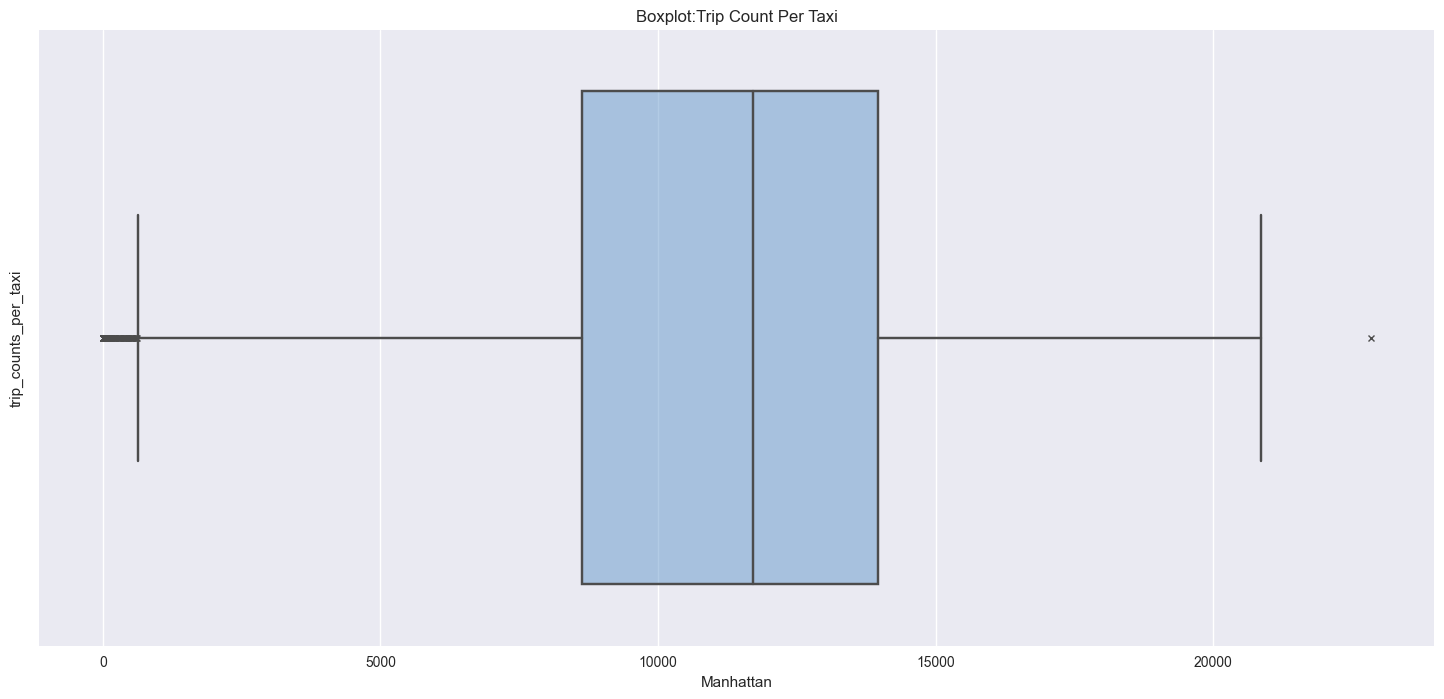

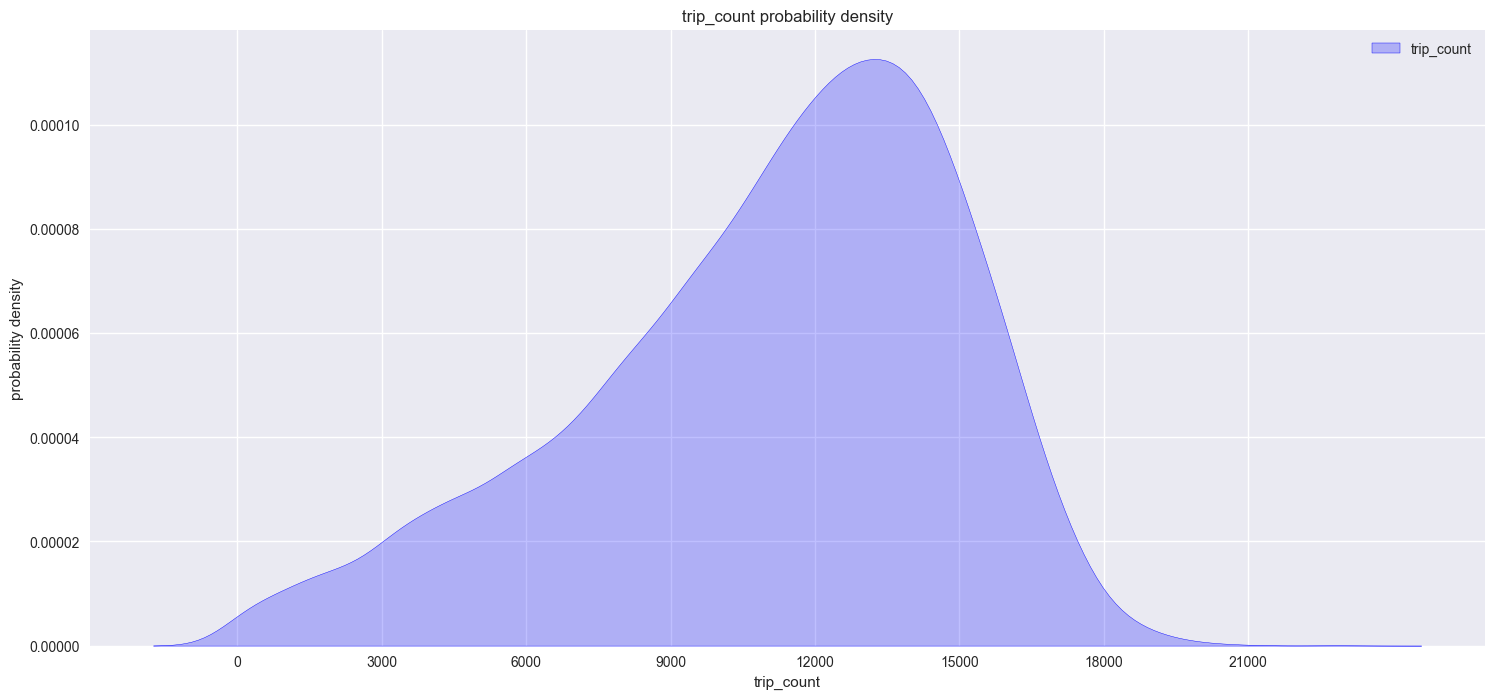


++++++++++Top Performers++++++++++

         trip_counts
taxi_id             
4816           22842
3341           20859
914            20684
2543           20135
2159           20098
8013           20040
2761           19938
3558           19826
462            19611
7112           19528


In [10]:
def plot_box(df:pd.DataFrame,field:str, xlabel: str, ylabel: str,
                 title: str, **kwargs):
    """simple box plot
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')
    fig = plt.figure(1, (18, 8), dpi=100)
    ax = plt.subplot(111)
    sns.boxplot(x=field,
                data=df,
                ax=ax,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def plot_kde(df: pd.DataFrame, topic="trip_counts"):
    """probability distribution plotting

    Args:
        df (pd.DataFrame): df containing data
        topic (str, optional): topic. Defaults to "distance".

    Raises:
        TypeError: _description_
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig = plt.figure(1,(18,8),dpi=100)
    ax = plt.subplot(111)
    if topic == "trip_counts":
        column = "trip_counts"
        xlabel = "trip_count"
        ylabel = "probability density"
        title = "trip_count probability density"
        step = 3000
    else:
        raise TypeError(f"Topic {topic} Not Found.")

    sns.kdeplot(
        data=df[column],
        fill=True,
        color="b",
        label=xlabel,
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, round(df[column].max()), step))
    plt.show()


plot_box(trips_distribution_per_taxi.reset_index(),"trip_counts","Manhattan","trip_counts_per_taxi","Boxplot:Trip Count Per Taxi")
plot_kde(trips_distribution_per_taxi.reset_index(),"trip_counts")



### Daily Trip count and pattern

In [11]:
trips_daily_counts = raw_taxi_df.groupby(['trip_date']).count()[[
    'taxi_id'
]].compute().rename({"taxi_id": "trip_count"}, axis=1)
trips_daily_counts


,trip_count
trip_date,
2011-01-01,149247
2011-01-02,128853
2011-01-03,313205
2011-01-04,345736
2011-01-05,376777
...,...
2011-12-27,318022
2011-12-28,347176
2011-12-29,385364


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


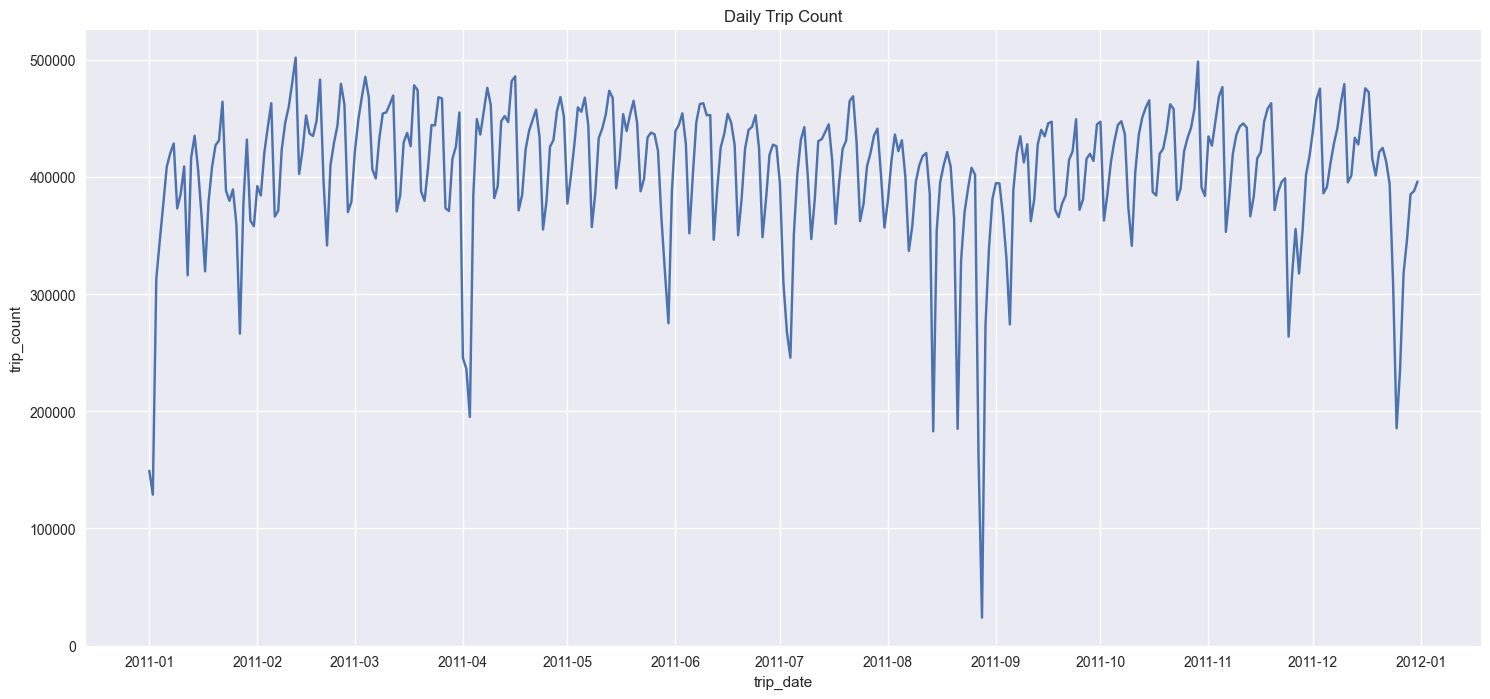

In [17]:
def plot_trend(
    df: pd.DataFrame,
    data_field="trip_count",
    x_column="trip_date",
    y_column="trip_count",
):
    """line chart, showing time trend

    Args:
        df (pd.DataFrame): dataframe
        data_field (str, optional): data field. 
        Defaults to "trip_count".
        x_column (str, optional): time field. 
        Defaults to "trip_date".
        y_column (str, optional): ylabel. 
        Defaults to "trip_count".
    """
    import matplotlib.dates as mdates

    # create figure
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    # plot
    sns.lineplot(
        y=data_field,
        x=x_column,
        data=df,
        # color="b",
        markers=True,
        ax=ax
    )

    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title("Daily Trip Count")
    plt.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.show()


plot_trend(trips_daily_counts)


### Task 4. Distribution of the number of trips **Departure&Arrival** aggregated by station

In [21]:
# generating gdf recording the number of trips departure and arrival based on stations.

# 1.For each trip, refering its departure station and count
merged_ddf = raw_taxi_df.merge(intersections_raw,
                               left_on="pick_up_intersection",
                               right_on="id")
departure_counter = merged_ddf.groupby(['pick_up_intersection']).count()[['taxi_id']].compute().rename({"taxi_id":"departure_counts"},axis = 1 )

# 2.For each trip, refering its arrival station and count
merged_ddf2 = raw_taxi_df.merge(intersections_raw,
                                left_on="drop_of_intersection",
                                right_on="id")
arrival_counter = merged_ddf2.groupby(["drop_of_intersection"]).count()[[
    'taxi_id'
]].compute().rename({"taxi_id": "arrival_counts"}, axis=1)

# Aftering grouping, generating geo-info for each station
departure_gdf = departure_counter.merge(intersections_raw,
                                        left_index=True,
                                        right_on="id")
departure_gdf['geometry'] = gpd.points_from_xy(departure_gdf["longitude"],
                                               departure_gdf['latitude'],
                                               crs="epsg:4326")
departure_gdf = gpd.GeoDataFrame(departure_gdf)

arrival_gdf = arrival_counter.merge(intersections_raw,
                                    left_index=True,
                                    right_on="id")
arrival_gdf['geometry'] = gpd.points_from_xy(arrival_gdf['longitude'],
                                             arrival_gdf['latitude'],
                                             crs="epsg:4326")
arrival_gdf = gpd.GeoDataFrame(arrival_gdf)


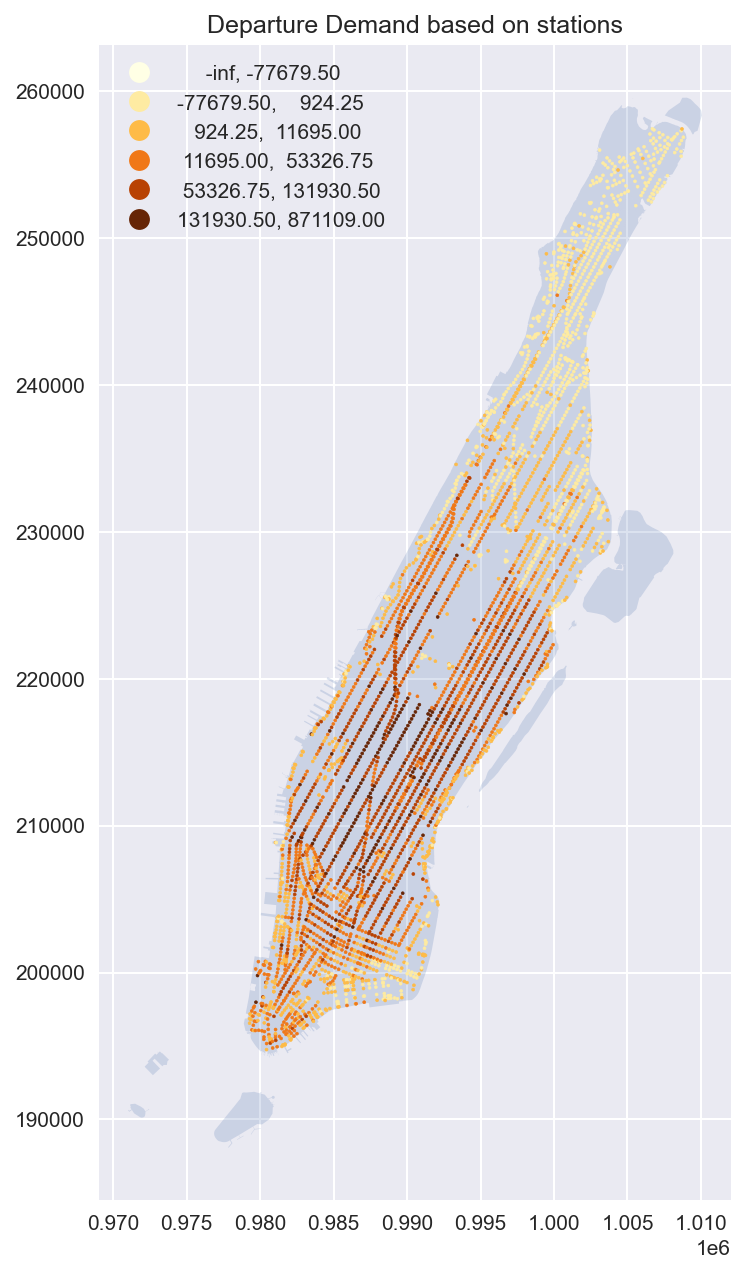

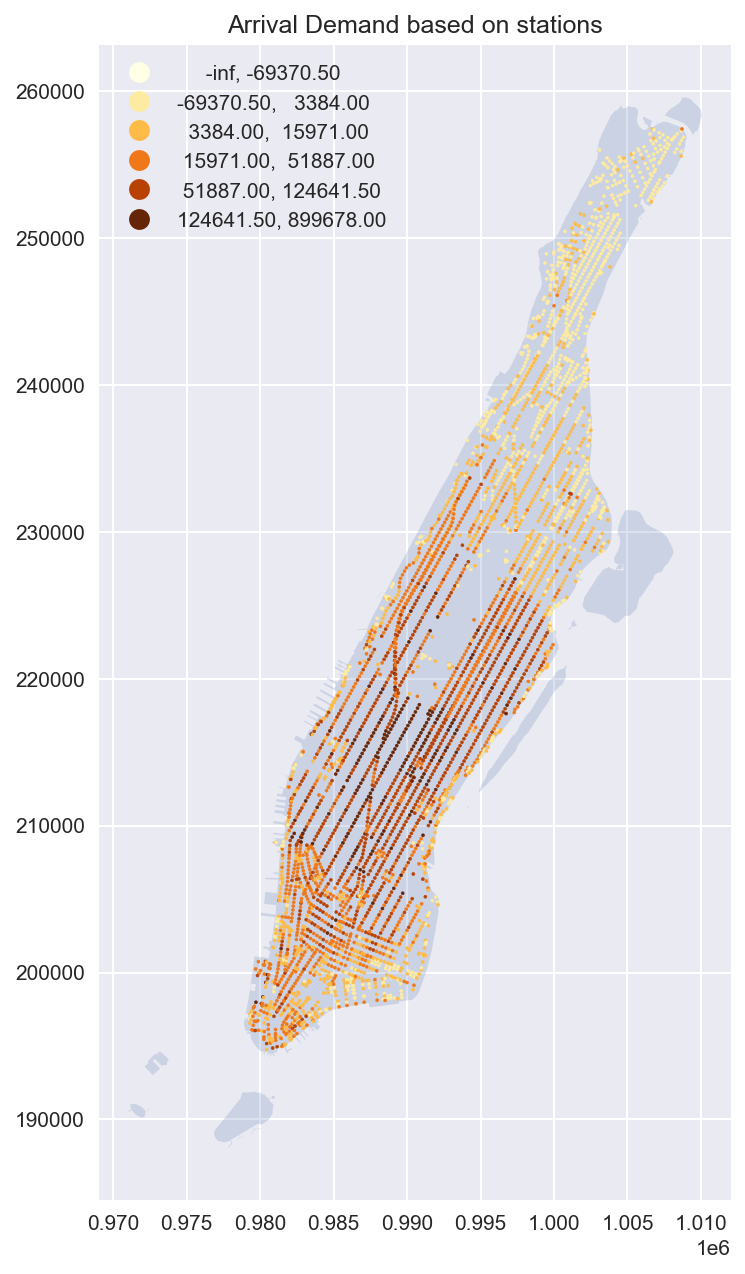

In [25]:
def plot_departure_demand_station():
    fig = plt.figure(1,(16,10),dpi = 150)
    ax = plt.subplot(111)
    boundary[boundary['borough'] == "Manhattan"].plot(ax=ax, alpha=0.2)
    departure_gdf.to_crs(f"epsg:{boundary.crs.to_epsg()}").plot(
        ax=ax,
        column="departure_counts",
        markersize=2,
        cmap="YlOrBr",
        legend=True,
        scheme="BoxPlot",
        k=4,
    )
    plt.title("Departure Demand based on stations")
    plt.show()

def plot_arrival_demand_station():
    fig = plt.figure(1, (16, 10), dpi=150)
    ax = plt.subplot(111)
    boundary[boundary['borough'] == "Manhattan"].plot(ax=ax, alpha=0.2)
    arrival_gdf.to_crs(f"epsg:{boundary.crs.to_epsg()}").plot(
        ax=ax,
        column="arrival_counts",
        markersize=2,
        cmap="YlOrBr",
        legend=True,
        scheme="BoxPlot",
        k=4,
    )
    plt.title("Arrival Demand based on stations")
    plt.show()
plot_departure_demand_station()
plot_arrival_demand_station()


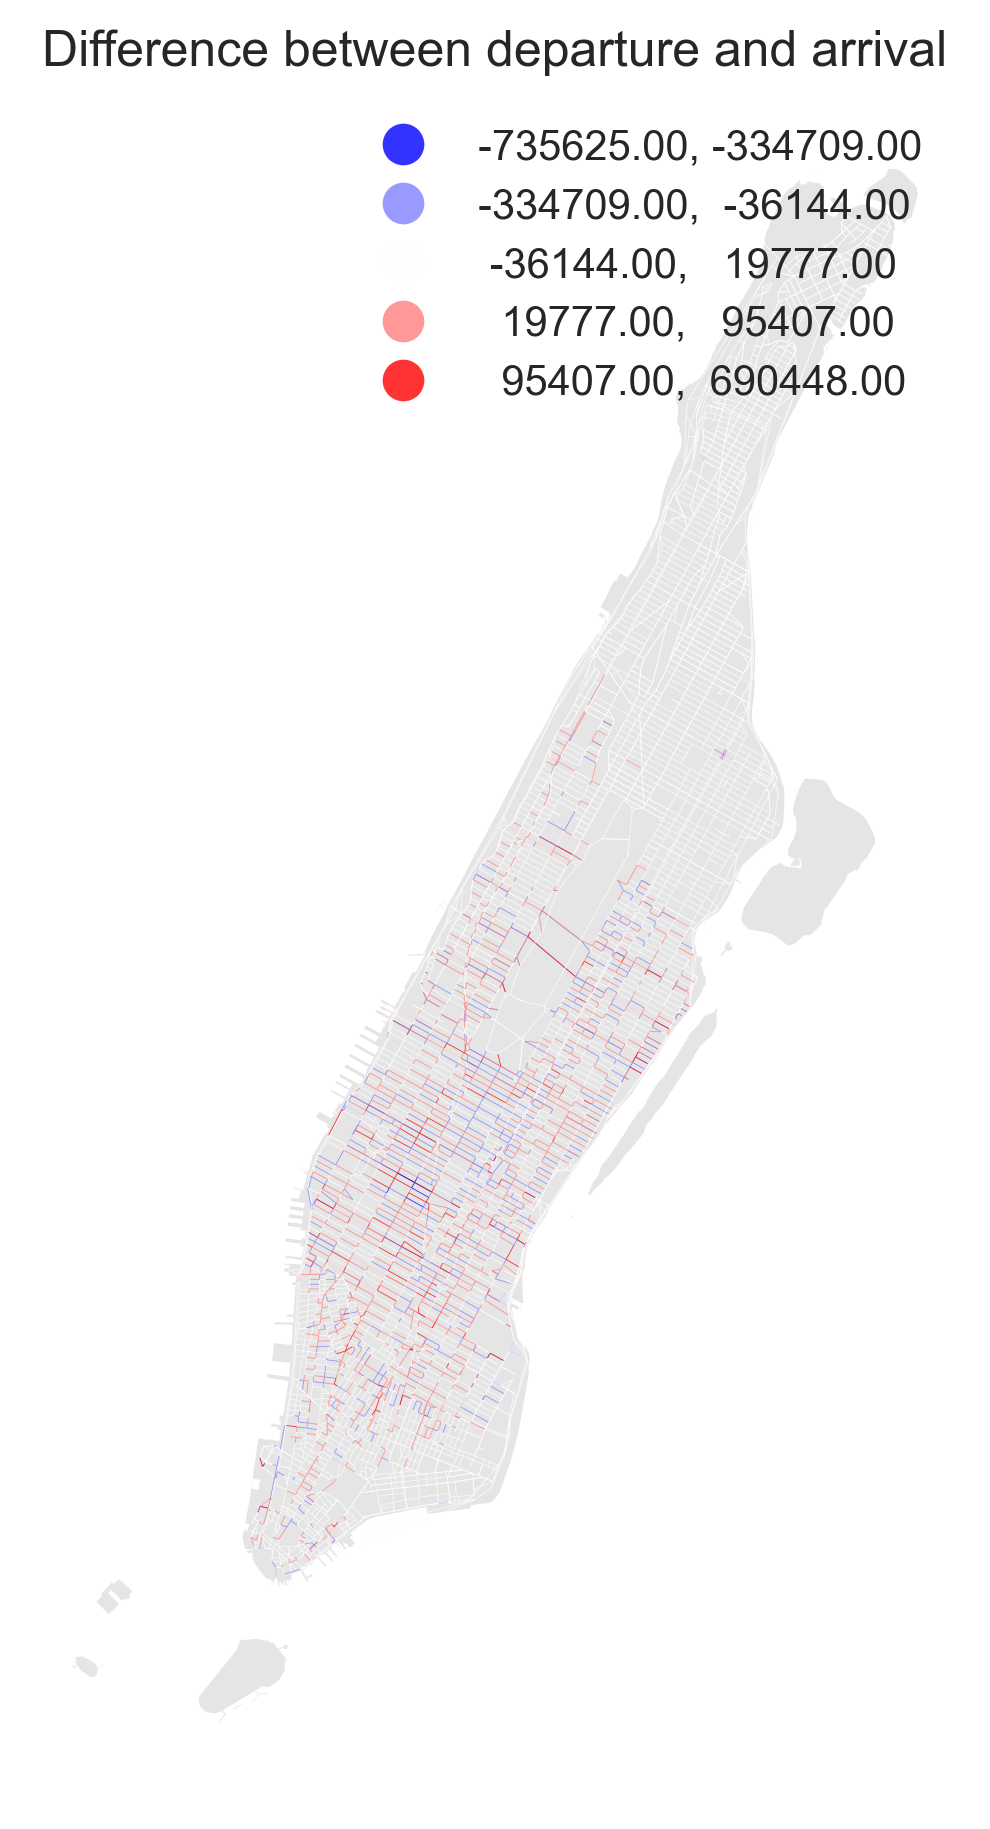

In [40]:
roads_intersection = intersection_to_road(roads=roads, intersections_raw=intersections_raw)
roads_recorder = roads_intersection.merge(departure_gdf[['id',"departure_counts"]],left_on = "node1",right_on = "id").drop(['id'],axis=1).merge(arrival_gdf[['id',"arrival_counts"]],left_on = "node2",right_on="id").drop(['id'],axis = 1)
roads_recorder['demand_diff']  = roads_recorder['departure_counts'] - roads_recorder['arrival_counts']

fig, ax = plt.subplots(1, 1, figsize=(4, 8), dpi=300)
boundary[boundary['borough'] == "Manhattan"].to_crs("epsg:4326").plot(
    ax=ax, alpha=0.2, facecolor="grey")
roads_recorder.plot(ax=ax,
                    column="demand_diff",
                    cmap="bwr",
                    linewidth=0.2,
                    scheme='NaturalBreaks',
                    alpha=0.8,
                    legend=True,
                    )

plt.title("Difference between departure and arrival")
plt.axis("off")
plt.show()


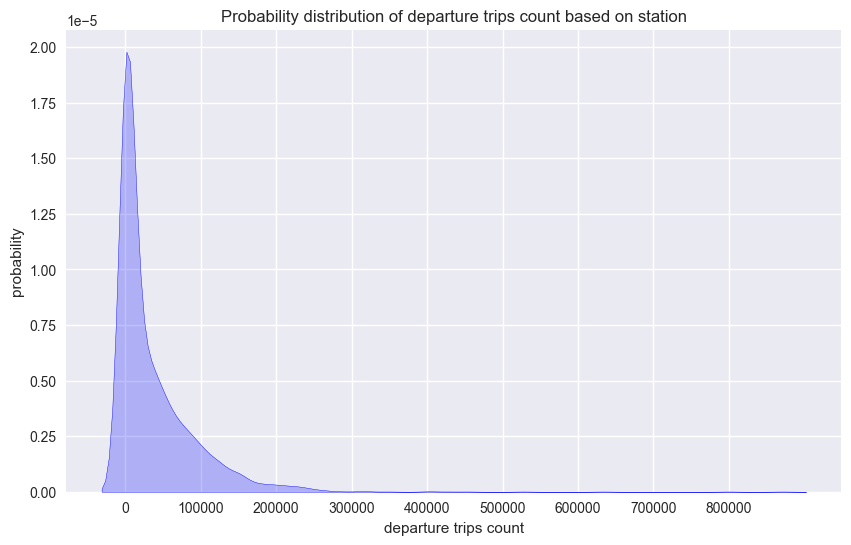

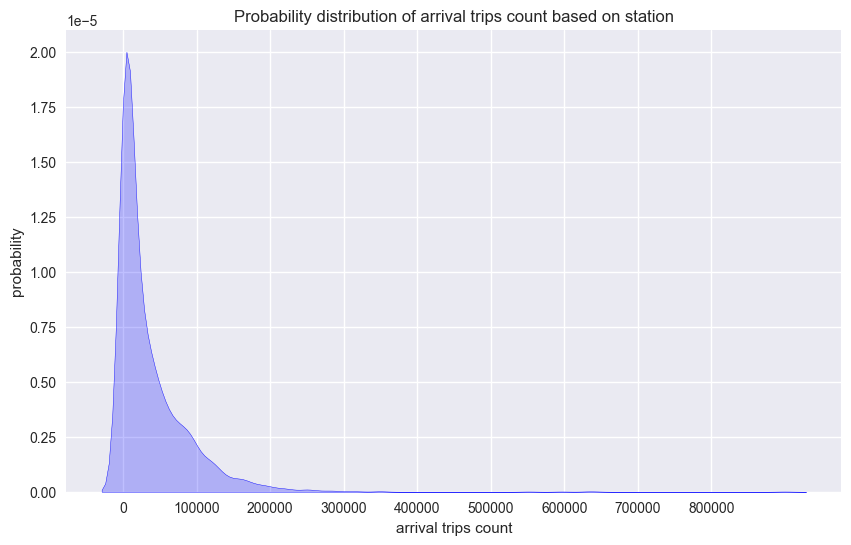

In [26]:
def plot_station_arrival_departure_kde(df, column, xlabel):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)

    sns.kdeplot(data=df[column], shade=True, color='b',ax=ax)
    plt.xlabel(xlabel)
    plt.ylabel("probability")

    plt.title(f"Probability distribution of {xlabel} based on station")
    plt.xticks(range(0,round(departure_gdf['departure_counts'].max()),100000))
    plt.show()


plot_station_arrival_departure_kde(departure_gdf,"departure_counts","departure trips count")
plot_station_arrival_departure_kde(arrival_gdf, "arrival_counts",
                                   "arrival trips count")


### Task 5. Number of trips over a day

In [ ]:
def plot_trend(
    df: pd.DataFrame,
    data_field="trip_count",
    x_column="trip_date",
    y_column="trip_count",
    emphasis_range=None,
):
    """line chart, showing time trend

    Args:
        df (pd.DataFrame): dataframe
        data_field (str, optional): data field. 
        Defaults to "trip_count".
        x_column (str, optional): time field. 
        Defaults to "trip_date".
        y_column (str, optional): ylabel. 
        Defaults to "trip_count".
        palette (list, optional): color space. 
        Defaults to ["#FF6B6B", "#FFD166", "#06D6A0", "#277DA1", "#FEAA40"].
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    macaron_colors = ["#FF6B6B", "#FFD166", "#06D6A0", "#277DA1", "#FEAA40"]
    # create figure
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    # plot
    sns.lineplot(
        y=data_field,
        x=x_column,
        data=df,
        # color="b",
        markers=True,
        ax=ax)
    plt.xticks(range(0, 24, 1))
    if len(emphasis_range) >= 1:
        plt.axvspan(
            emphasis_range[0][0],
            emphasis_range[0][1],
            alpha=0.2,
            color=macaron_colors[0],
            label=
            f"Rush Hour ({emphasis_range[0][0]}:00-{emphasis_range[0][1]}:00)",
        )
        plt.axvspan(
            emphasis_range[1][0],
            emphasis_range[1][1],
            alpha=0.2,
            color=macaron_colors[1],
            label=
            f"Rush Hour ({emphasis_range[1][0]}:00-{emphasis_range[1][1]}:00)",
        )
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title("Daily Trip Count")
    plt.legend()
    plt.show()


In [42]:
# 1. randomly select 3 days in the dataset range
date_sample1, date_sample2, date_sample3 = pd.to_datetime(
    (pd.date_range('2011-01-01',
                   periods=364).to_series().sample(
                       n=3).to_list())).strftime('%Y-%m-%d')
date_sample1


'2011-02-24'

In [43]:
# calculating the groupping result, groupping rules:by=["trip_date", "trip_hour"]

hourly_trend_in_days = nytz_df[(nytz_df["trip_date"] == date_sample1) |
                       (nytz_df["trip_date"] == date_sample2) |
                       (nytz_df["trip_date"] == date_sample3)][[
                           'trip_date', "trip_hour", "taxi_id"
                       ]].groupby(
                           by=["trip_date", "trip_hour"]).count().rename(
                               columns={"taxi_id": "trip_count"})
_hourly_groupping_res = hourly_trend_in_days.compute()
_hourly_groupping_res


trip_count
trip_date  trip_hour            
2011-02-24 00               2781
           01               9973
           02              20432
           03              25929
           04              25371
...                          ...
2011-09-03 19              22406
           20              21443
           21              17446
           22              14403
           23              10941

[72 rows x 1 columns]

<Axes: >

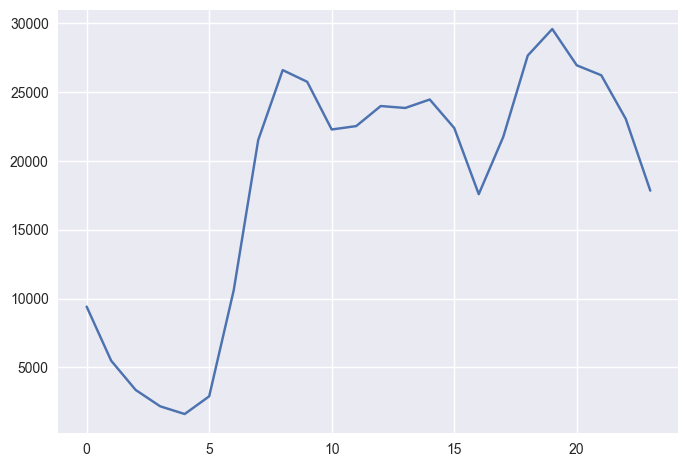

In [26]:
for _date in [date_sample1,date_sample2,date_sample3]:
    _hourly_groupping_res[_raw_res['trip_date'] ==
                          "2011-06-01"]['trip_count'].plot()


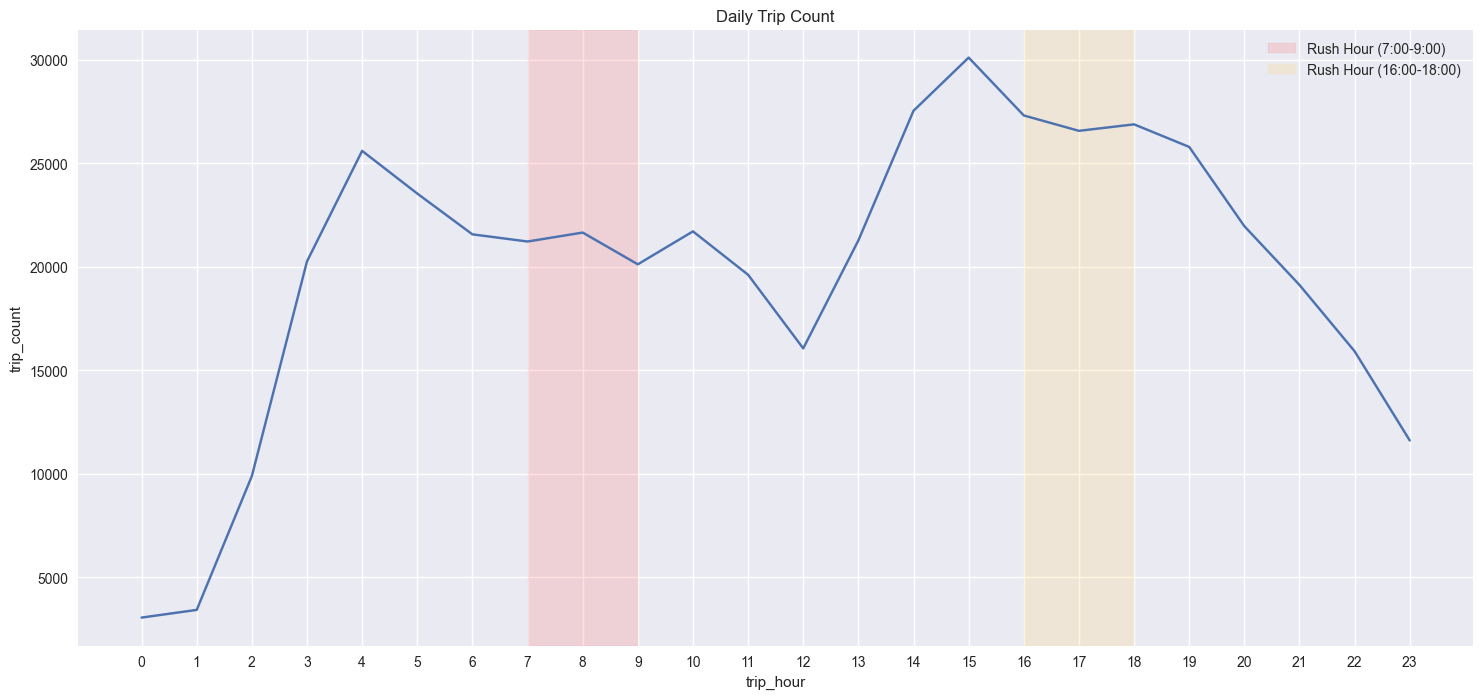

In [24]:
plot_trend(_hourly_data,data_field="trip_count",x_column="trip_hour",y_column="trip_count",emphasis_range=[(7,9),(16,18)])


### Task 6. Probability distribution of trip distance and trip duration

In [45]:
def plot_travel_distance_kde(series):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)

    sns.kdeplot(data=series, shade=True, color='b', ax=ax)
    plt.xlabel("Travel Distance")
    plt.ylabel("probability")

    plt.title(f"Probability distribution of travel distance (1% Sample)")
    plt.xticks(range(0, round(series.max()), 5000))
    plt.show()


def plot_travel_time_kde(series):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    data = series[series < series.quantile(0.99)]
    sns.kdeplot(data=data, shade=True, color='b', ax=ax)
    plt.xlabel("Travel Time")
    plt.ylabel("probability")

    plt.title(f"Probability distribution of travel time (1% Sample)")
    plt.xticks(
        range(0, round(series.quantile(0.99)),
              round(series.quantile(0.99) / 10)))
    plt.show()


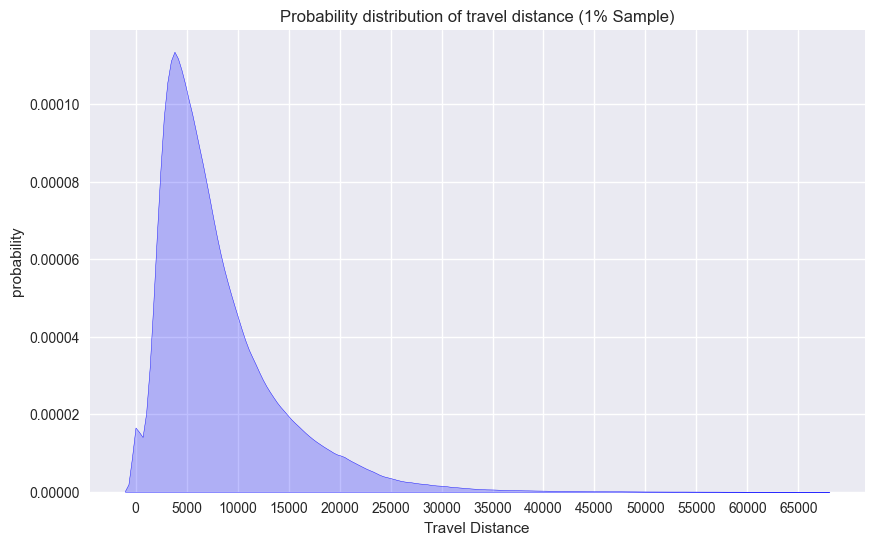

In [46]:
# 1. calculating the distance between departure station and arrival station for each trip
intersections_raw['geometry'] = gpd.points_from_xy(
    intersections_raw['longitude'], intersections_raw['latitude'])
intersections_geom = gpd.GeoDataFrame(
    intersections_raw[['id', "geometry"]],
    crs="epsg:4326").to_crs("epsg:2263").set_index("id")

geom_related_df = raw_taxi_df[['pick_up_intersection', "drop_of_intersection"]]

dgdf_departure_arrival = dgpd.from_dask_dataframe(geom_related_df.merge(intersections_geom,left_on="pick_up_intersection",right_index=True).merge(intersections_geom,left_on='drop_of_intersection',right_index =  True)[['geometry_x',"geometry_y"]])
dgdf_trip_distance = dgdf_departure_arrival['geometry_x'].distance(
    dgdf_departure_arrival['geometry_y']).compute()

# Down sampling to 1% of the data due to the comlexity in calculating probability density.
trip_distance_sample = dgdf_trip_distance.sample(int(0.01 * len(dgdf_trip_distance)),
                                   random_state=42)
# visualizing probability distribution of trip_distance
plot_travel_distance_kde(trip_distance_sample)


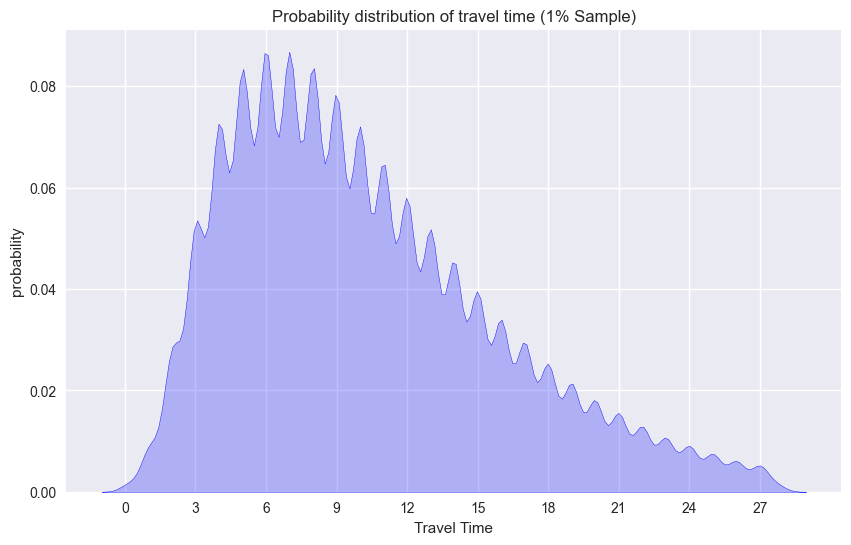

In [48]:
# calculating travel duration by <end_time - start_time>
travel_time_ddf = (raw_taxi_df['drop_off_time'] -
                  raw_taxi_df['pick_up_time']).compute()

# calculating trip duration and converting into minutes
trip_duration_sample = (travel_time_ddf.dt.seconds / 60).round(2).sample(
    int(0.01 * len(travel_time_ddf)), random_state=42)
_trip_duration_sample = trip_duration_sample[
    trip_duration_sample <= trip_duration_sample.quantile(0.99)].reset_index(
        drop=True)

# plotting
plot_travel_time_kde(_trip_duration_sample)


### exploring why the probability distribution of travel time is weird

In [50]:
# groupping the travel time and sorting them from high to low
groupping_by_mintue = _trip_duration_sample.to_frame(
    name="minutes").reset_index().groupby("minutes").count().rename(
        {
            "index": "count"
        }, axis=1).sort_values(by="count", ascending=False).head(50)
groupping_by_mintue

# You will find that most travel times are approximated to minutes in integer

,count
minutes,
6.00,55292
7.00,55176
8.00,53689
5.00,52579
9.00,50700
10.00,46869
4.00,45143
11.00,41838
12.00,37566
